In [1]:
from sklearn.datasets import make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## MCMC sampling method

In [2]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

## Laplacian kernel delta density function (Gamma distribution)

In [3]:
def p(delta):
    if delta < 0.:
        return 0.
    else:
        return delta * np.exp(-delta)

## One_hot vector generation function

In [4]:
def one_hot(dim, pos):
    vec = np.zeros(int(dim))
    vec[int(pos)] = 1.
    return vec

## Function to computer the dot product between the one-hot grids

In [5]:
def dot_product(x1, x2):
    s = 0
    for i in range(len(x1)):
        for j in range(x1[i].shape[0]):
            s += np.dot(x1[i][j], x2[i][j])
    return s

## Random binning features SVM class

In [6]:
class random_binning_features_svm:
    def __init__(self, P=30):
        self.P = P
        
    def _draw_grid_params(self, P, d, spans, max_iter=1000):
        deltas = np.zeros((P, d))
        us = np.zeros((P, d))
        num_of_bins_collect = []

        # draw grid parameters
        for i in range(P):
            s = metropolis_hastings(p, 1, iter=max_iter)
            delta = s[np.random.randint(low=20, high=max_iter, size=d)]
            u =  np.random.uniform(low=0, high=delta)
            delta = delta.reshape(delta.shape[0])
            u = u.reshape(u.shape[0])
            deltas[i, :] = delta
            us[i, :] = u
            num_of_bins = (np.ceil((spans) / delta)).astype("int") + 1
            num_of_bins_collect.append(num_of_bins)
        
        self.num_of_bins_collect = num_of_bins_collect
        self.deltas = deltas
        self.us = us
    
    def _feature_mapping(self, X, num_of_bins_collect, deltas, us):
        X_feature_map = []
        lower = np.min(X, axis=0)

        for i in range(X.shape[0]):
            x = X[i]
            X_map = []

            for j in range(self.P):
                bin_idx = (np.ceil((x - lower - us[j, :]) / deltas[j, :])).astype("int")
                X_map.append(np.array([np.sqrt(1/self.P) * one_hot(dim, pos) for dim, pos in zip(num_of_bins_collect[j], bin_idx)]))
            X_feature_map.append(X_map)
            
        return X_feature_map
    
    def fit(self, X_train, y_train, C=10):
        spans = np.zeros(X_train.shape[-1])
        for i in range(X_train.shape[-1]):
            spans[i] = np.max(X_train[:, i]) - np.min(X_train[:, i])
            
        print("feature mapping the training data")
        d = X_train.shape[-1]
        self._draw_grid_params(self.P, d, spans)
        X_train_map = self._feature_mapping(X_train, self.num_of_bins_collect, self.deltas, self.us)
        print("computing gram matrix")
        taille = len(X_train_map)
        K = np.zeros((taille, taille))
        for i in range(taille):
            for j in range(taille):
                K[i, j] = dot_product(X_train_map[i], X_train_map[j])
        m = K.shape[0]
        y_train = y_train.reshape(-1,1) * 1.
        H = np.outer(y_train, y_train) * K
        H.shape

        P = matrix(H)
        q = matrix(-np.ones(m))
        G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = matrix(y_train, (1, m))
        b = matrix(0.)

        #Run solver
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])

        alphas = alphas.reshape(alphas.shape[0])

        sup_vec_idx = np.argwhere(np.logical_or(alphas > 1e-4, alphas < -1e-4))
        sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
        
        print("calculating weight and bias")
        weights = []
        for i in range(self.P):
            temp = []
            for j in range(len(X_train_map[0][i])):
                temp.append(np.zeros(X_train_map[0][i][j].shape))
            weights.append(np.array(temp))

        for idx in sup_vec_idx:
            for j in range(self.P):
                weights[j] += X_train_map[idx][j] * y_train[idx] * alphas[idx]
        
        y_train = y_train.reshape(y_train.shape[0])
        minus_idx = (np.argwhere(y_train == -1)).squeeze()
        max_val = -np.inf
        for i in minus_idx:
            val = dot_product(X_train_map[i], weights)
            if val > max_val:
                max_val = val

        plus_idx = (np.argwhere(y_train == 1)).squeeze()
        min_val = np.inf
        for i in plus_idx:
            val = dot_product(X_train_map[i], weights)
            if val < min_val:
                min_val = val

        bias = - (max_val + min_val) / 2
        
        self.weights = weights
        self.bias = bias
        
    def predict(self, X_test):
        print("feature mapping the test data")
        X_test_map = self._feature_mapping(X_test, self.num_of_bins_collect, self.deltas, self.us)
        pred = []
        for x in X_test_map:
            pred.append(np.sign(dot_product(x, self.weights) + self.bias))
        pred = np.array(pred)
        return pred

## load nonlinear dataset

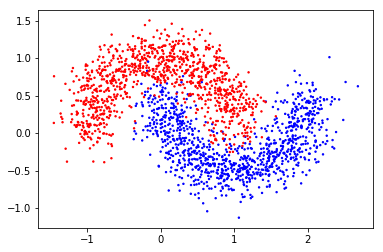

In [7]:
X, y = make_moons(n_samples=2000, noise=0.2)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [8]:
clf = random_binning_features_svm()
clf.fit(X_train, y_train)

feature mapping the training data


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


computing gram matrix
     pcost       dcost       gap    pres   dres
 0: -1.5584e+03 -1.2218e+05  3e+05  9e-01  6e-14
 1: -1.2414e+02 -3.8416e+04  6e+04  1e-01  6e-14
 2:  7.5372e+01 -1.1008e+04  1e+04  2e-02  6e-14
 3: -3.5766e+02 -3.9874e+03  4e+03  5e-03  5e-14
 4: -7.0464e+02 -2.1089e+03  1e+03  1e-03  6e-14
 5: -8.7364e+02 -1.4623e+03  6e+02  3e-04  6e-14
 6: -9.3444e+02 -1.2922e+03  4e+02  1e-04  7e-14
 7: -1.0041e+03 -1.1007e+03  1e+02  1e-05  7e-14
 8: -1.0196e+03 -1.0698e+03  5e+01  4e-06  7e-14
 9: -1.0315e+03 -1.0475e+03  2e+01  7e-07  7e-14
10: -1.0345e+03 -1.0422e+03  8e+00  3e-13  8e-14
11: -1.0370e+03 -1.0388e+03  2e+00  6e-14  7e-14
12: -1.0377e+03 -1.0378e+03  1e-01  3e-14  8e-14
13: -1.0377e+03 -1.0377e+03  1e-03  2e-13  8e-14
Optimal solution found.
calculating weight and bias


## Test set accuracy

In [9]:
pred = clf.predict(X_test)
np.sum((pred == y_test).astype("int")) / y_test.shape[0]

feature mapping the test data


0.9675